# Preparation

Install the nightly versions of PyTorch and Torchvision as the latest release does not yet provide the pretrained weights for DeepLabV3 with a ResNet-50 backbone.

In [ ]:
! pip uninstall -y torch
! pip uninstall -y torchvision
! pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Imports

In [ ]:
import colorsys
import copy
import datetime
import errno
import json
import math
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
import random
import scipy
import seaborn as sns
import shutil
import sys
import time 
import random
import torch
import torch.distributed as dist
import torch.nn.functional as nn_func
import torch.utils.data
import torchvision
import urllib.request
import warnings


from collections import defaultdict, deque
from matplotlib import colors
from PIL import Image, ExifTags
from pycocotools import mask as maskUtils
from pycocotools.coco import COCO
from torch import nn
from torchvision import transforms


np.random.seed(1)

# Download dataset

Downloads the resized TACO dataset and the accompanying masks that were generated in a separate notebook.

In [ ]:
from pathlib import Path
import urllib.request
import os
from google.colab import files

!pip install -q kaggle

def download_data(replace=False, dataset_name = "taco-dataset-resized-640", dataset_destination = "taco-dataset-resized-640"):
  if replace or not Path(f"/content/{dataset_destination}").exists():
    print(f"Downloading and unpacking {dataset_name}...")
    os.environ['KAGGLE_USERNAME'] = "verahoveling"
    os.environ['KAGGLE_KEY'] = "1553f496337ebdcc5b2b6710de4fb748" 
    !kaggle datasets download "verahoveling/"$dataset_name
    !unzip -q "/content/"$dataset_name".zip" -d $dataset_destination


def download_masks(replace=False, dataset_name = "taco-dataset-resized-640-masks", dataset_destination = "taco-dataset-resized-640-masks"):
  if replace or not Path(f"/content/{dataset_destination}").exists():
    print(f"Downloading and unpacking {dataset_name}...")
    os.environ['KAGGLE_USERNAME'] = "sranjha"
    os.environ['KAGGLE_KEY'] = "57d3733a9bceac9771f0295b9f791080" 
    !kaggle datasets download "sranjha/"$dataset_name
    !unzip -q "/content/"$dataset_name".zip" -d $dataset_destination


download_data(replace=False)
download_masks(replace=False)

# Dataset

The `TacoDataset` class that returns a `torch.utils.data.Dataset` representation of the TACO dataset, such that it can be used in the `torch.utils.data.DataLoader`. 

If `usePadding` is true, the images will be padded to 640x640 as these are the largest width and height that occur in our resized version of the TACO dataset. Padding the images allows us to use batches during training, as PyTorch does not allow batches with images of different dimensions. 

If `randomCrop` is true, the images will be randomly cropped to 400x400 images. The idea is that taking a random crop of an image each time provides some data augmentation and will prevent the model from overfitting on the entire image. 

In [ ]:
class TacoDataset(torch.utils.data.Dataset):
    def __init__(self, img_root, mask_root, annotation_file, normalization=None, transforms=None, usePadding=True, randomCrop=False):
        self.img_root = img_root
        self.mask_root = mask_root
        self._image_ids = []
        self.transforms = transforms
        self.imgs = {}
        self.masks = {}
        self.usePadding = usePadding
        self.randomCrop = randomCrop
        self.normalization = normalization

        annotations = json.load(Path(annotation_file).open("r"))
        images = annotations['images']
        for image in images:
            image_path = Path(img_root).joinpath(image['file_name'])
            image_id = image['id']
            mask_path = Path(mask_root).joinpath(f"{image_id}.pt")
            self._image_ids.append(image_id)

            self.imgs[image_id] = image_path
            self.masks[image_id] = mask_path

    @property
    def image_ids(self):
        return self._image_ids


    def load_image(self, idx):
        """Load the specified image and return as a [H,W,3] Numpy array."""
        image = Image.open(Path(self.img_root).joinpath(self.imgs[idx]))
        img_shape = np.shape(image)

        # load metadata
        exif = image._getexif()
        if exif:
            exif = dict(exif.items())
            # Rotate portrait images if necessary (274 is the orientation tag code)
            if 274 in exif:
                if exif[274] == 3:
                    image = image.rotate(180, expand=True)
                if exif[274] == 6:
                    image = image.rotate(270, expand=True)
                if exif[274] == 8:
                    image = image.rotate(90, expand=True)

        # If has an alpha channel, remove it for consistency
        if img_shape[-1] == 4:
            image = image[..., :3]

        return np.array(image)

    @staticmethod
    def pad(image, target):
        # padding_left, padding_right, padding_top, padding_bottom
        pad_left = 640 - image.shape[2]
        pad_bottom = 640 - image.shape[1]
        image = torch.nn.functional.pad(image, pad=(0, pad_left, 0, pad_bottom), mode='constant', value=255)
        target = torch.nn.functional.pad(target, pad=(0, pad_left, 0, pad_bottom), mode='constant', value=255)
        
        return (image, target)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        image = self.load_image(idx)
        image = np.moveaxis(image, [0, 1, 2], [1, 2, 0])
        image_tensor = torch.tensor(image)
        image_tensor = image_tensor.float()
        image_tensor = image_tensor / 255
        mask = torch.load(Path(self.mask_root).joinpath(self.masks[idx]))

        if self.transforms is not None:
            image_tensor, mask = self.transforms(image_tensor, mask)
        if self.normalization is not None:
            image_tensor = self.normalization(image_tensor)

        mask = mask.long()

        if self.randomCrop:
          image_tensor, mask = self.pad(image_tensor, mask)
          i, j, h, w = transforms.RandomCrop.get_params(image_tensor, output_size=(400, 400))
          cropped_image = image_tensor[:, i:i + h, j:j + w]
          cropped_mask = mask[i:i + h, j:j + w]
          return (cropped_image, cropped_mask)
        elif self.usePadding:
          return self.pad(image_tensor, mask)
        else: 
          return (image_tensor, mask)            

## Data augmentation
Functions to perform data augmentation similar to the data augmentation performed by [TACO](https://github.com/pedropro/TACO) when training Mask R-CNN on the TACO dataset

In [ ]:
# https://imgaug.readthedocs.io/en/latest/_modules/imgaug/augmenters/blur.html#GaussianBlur
def _compute_gaussian_blur_ksize(sigma):
    if sigma < 3.0:
        ksize = 3.3 * sigma  # 99% of weight
    elif sigma < 5.0:
        ksize = 2.9 * sigma  # 97% of weight
    else:
        ksize = 2.6 * sigma  # 95% of weight

    # we use 5x5 here as the minimum size as that simplifies
    # comparisons with gaussian_filter() in the tests
    # TODO reduce this to 3x3
    ksize = int(max(ksize, 5))
    ksize = ksize + 1 if ksize % 2 == 0 else ksize
    return ksize  

# https://github.com/kechan/FastaiPlayground/blob/master/Quick%20Tour%20of%20Data%20Augmentation.ipynb
def _gaussian_kernel(kernel_size, sigma=2., dim=2, channels=3):
    # The gaussian kernel is the product of the gaussian function of each dimension.
    # kernel_size should be an odd number.
    
    # kernel_size = _compute_gaussian_blur_ksize(sigma)
    
    # kernel_size = 2*size + 1

    kernel_size = [kernel_size] * dim
    sigma = [sigma] * dim
    kernel = 1
    meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])
    import math 
    for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
        mean = (size - 1) / 2
        kernel *= 1 / (std * math.sqrt(2 * math.pi)) * torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

    # Make sure sum of values in gaussian kernel equals 1.
    kernel = kernel / torch.sum(kernel)

    # Reshape to depthwise convolutional weight
    kernel = kernel.view(1, 1, *kernel.size())
    kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

    return kernel

def _pad_if_smaller(image, mask, size = 400):
  height, width = image.shape[-2:]
  min_size = min(height, width)
  if min_size < size:
    padh = size - height if height < size else 0
    padw = size - width if width < size else 0
    image = nn_func.pad(image, pad=(padw/2, padw/2, padh/2, padh/2), mode='constant', value=255)
    mask = nn_func.pad(mask, pad=(padw/2, padw/2, padh/2, padh/2), mode='constant', value=255)

  return image, mask

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, mask):
        for t in self.transforms:
            image, mask = t(image, mask)
        return image, mask

class RandomHorizontalFlip(object):
    def __init__(self, prob = 0.5):
        self.prob = prob

    def __call__(self, image, mask):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
  
            mask = mask.flip(-1)
            
        return image, mask

class RandomVerticalFlip(object):
    def __init__(self, prob = 0.5):
        self.prob = prob

    def __call__(self, image, mask):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
  
            mask = mask.flip(-2)
            
        return image, mask

class RandomCrop(object):
  def __init__(self, size = 400):
    self.size = size
  
  def __call__(self, image, mask):
    """Image: image tensor
        Target: Target DICT"""
    height, width = image.shape[-2:]
    image, mask = _pad_if_smaller(image, mask, size=self.size)
    i, j, h, w = tf.RandomCrop.get_params(image, output_size=(self.size, self.size))
    image = image[:, i:i + h, j:j + w]
    mask = mask[i:i + h, j:j + w]
    return image, mask

class AdditiveGaussianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.std = std
    self.mean = mean

  def __call__(self, image, mask):
    return image + torch.randn(image.shape) * self.std + self.mean, mask

# https://github.com/kechan/FastaiPlayground/blob/master/Quick%20Tour%20of%20Data%20Augmentation.ipynb
class GaussianBlur(object):
  def __init__(self, sigma=0.0):
    self.sigma = sigma

  def __call__(self, image, mask):
    kernel_size = _compute_gaussian_blur_ksize(self.sigma)
    kernel = _gaussian_kernel(kernel_size)

    image = image[None,...]
    padding = int((kernel_size - 1) / 2)
    image = nn_func.pad(image, (padding, padding, padding, padding), mode="reflect")
    image = torch.squeeze(nn_func.conv2d(image, kernel, groups=3))

    return image, mask

## Model and dataloaders
Functions to retrieve the dataset, data samplers, data loaders and the DeepLabV3 model initialized with the pretrained weights. 

- `get_taco_dataset` applies the normalization on the images using the same transformation that was used to pretrain the model.  
- `get_samplers` returns random samplers where the dataset is randomly split into train, validation and test sets using the specified ratios.
- `get_dataloaders` returns dataloaders using the random samplers for the train, validation, and test sets.
- The original DeepLabV3 model is trained on 21 classes, while the TACO dataset contains 29 classes (28 object classes + background). Hence, in `get_deeplab_model` we replace the last layer of the classifiers to output 29 channels instead of 21. 

In [ ]:
def get_taco_dataset(usePadding=True, randomCrop=False, augmentation=False):
  if augmentation:
    augmentations = Compose([
        AdditiveGaussianNoise(std = 0.225),
        GaussianBlur(),
        RandomHorizontalFlip(),
        RandomVerticalFlip()
    ])
  else:
    augmentations = None


  preprocess = transforms.Compose([
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  return TacoDataset('/content/taco-dataset-resized-640/content', '/content/taco-dataset-resized-640-masks/masks_pt', '/content/taco-dataset-resized-640/content/annotations.json', normalization=preprocess, transforms=augmentations, usePadding=usePadding, randomCrop=randomCrop)

def get_samplers(dataset, val_split=0.1, test_split=0.1, shuffle_dataset=True):
  dataset_size = len(dataset.image_ids)
  indices = list(range(dataset_size))
  val_split = int(np.floor(val_split * dataset_size))
  test_split = int(np.floor(test_split * dataset_size))

  np.random.seed(1)
  if shuffle_dataset :
      np.random.shuffle(indices)
  train_indices = indices[(test_split+val_split):]
  val_indices = indices[test_split:(test_split+val_split)]
  test_indices = indices[:test_split]
  print(test_indices)

  train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
  val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
  test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)


  return train_sampler, val_sampler, test_sampler

def get_dataloaders(dataset, batch_size, shuffle_dataset=True, collate_fn=None, test_batch_size=1):
  train_sampler, val_sampler, test_sampler = get_samplers(dataset=dataset, shuffle_dataset=shuffle_dataset)
  
  train_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=batch_size, 
                                     drop_last=True, 
                                     sampler=train_sampler,
                                     collate_fn=collate_fn)
  
  val_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=test_batch_size, 
                                     drop_last=True, 
                                     sampler=val_sampler,
                                     collate_fn=collate_fn)
  
  test_loader = torch.utils.data.DataLoader(dataset, 
                                     batch_size=test_batch_size, 
                                     drop_last=True, 
                                     sampler=test_sampler,
                                     collate_fn=collate_fn)
  
  return train_loader, val_loader, test_loader

def get_deeplab_model(aux_loss, num_classes=29, pretrained=True):
  model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=pretrained, progress=True, aux_loss=aux_loss)
  if aux_loss:
    model._modules['aux_classifier'][-1] = torch.nn.Conv2d(256, num_classes, 1)
  model._modules['classifier'][-1] = torch.nn.Conv2d(256, num_classes, 1)
  
  return model


# Train and evaluate DeepLab

## Utility functions

Functions for evaluating the losses. 
`_fast_hist` and `scores` are borrowed from https://github.com/kazuto1011/deeplab-pytorch/blob/master/libs/utils/metric.py with some changes.

In [ ]:
def get_loss(data_loader, net, criterion, device, weights) -> float:
  """Get average loss on the data in the given dataloader.
  
  Params
  ------
  data_loader: DataLoader
    has the data over which the loss should be computed

  net: nn.Module
    neural net that produces an output

  criterion: 
    loss function

  """

  net.eval()
  if weights:
    weights = weights.to(device)

  running_loss = 0
  for (image, label) in data_loader:
    image = image.to(device)
    label = label.to(device)
    out = net(image)

    loss = criterion(out, label, weights)
    running_loss += loss.item() * image.size(0)
    
  return running_loss / len(data_loader)

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask] + label_pred[mask],
        minlength=n_class ** 2,
    ).reshape(n_class, n_class)
    return hist

def scores(label_trues, label_preds, n_class):
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        lt = lt.to('cpu')
        lp = lp.to('cpu')
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    iu = np.nan_to_num(np.diag(hist) / (np.nansum(hist, axis=1) + np.nansum(hist, axis=0) - np.diag(hist)))
    valid = hist.sum(axis=1) > 0
    mean_iu = np.nanmean(iu[valid])
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    cls_iu = dict(zip(range(n_class), iu))
    return {
        "Pixel Accuracy": acc,
        "Mean Accuracy": acc_cls,
        "Frequency Weighted IoU": fwavacc,
        "Mean IoU": mean_iu,
        "Class IoU": cls_iu,
    }

def evaluate_metrics(model, test_loader, num_classes):
  model.eval()
  labels = []
  outputs = []

  for i, (image, label) in enumerate(test_loader):      
    image = image.cuda(0)
    output = model(image)
    output = output['out']
    
    labels.append(label)
    outputs.append(output.argmax(1))

  return scores(labels, outputs, num_classes)

Functions for logging the training progress. Borrowed from Pytorch.

In [ ]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))

def get_rank():
    return 0


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)

Functions for training the model. Borrowed from PyTorch but largely adapted to suit our own needs.

In [ ]:
def criterion(inputs, target, weights=None):
    losses = {}
    for name, x in inputs.items():
      losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255, weight=weights)

    if len(losses) == 1:
        return losses['out']

    return losses['out'] + 0.5 * losses['aux']

def train_one_epoch(model, criterion, optimizer, data_loader, lr_scheduler, device, epoch, print_freq, weights):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value}'))
    header = 'Epoch: [{}]'.format(epoch)

    if weights:
      weights = weights.to(device)
    running_loss = 0.0
    for image, target in metric_logger.log_every(data_loader, print_freq, header):
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target, weights)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])

        running_loss += loss.item() * image.size(0)

    return running_loss / len(data_loader)

def train_deeplab(train_loader, val_loader, aux_loss=True, lr=0.0001, momentum=0.9, 
          weight_decay=1e-4, epochs=30, num_classes=29,
          batch_size=2, output_dir="/content", print_freq=10,
          checkpoint_path=None, weights=None): 

  f = open(f'{output_dir}/losses.txt', 'a')
  f.write('Epoch,Train_loss,Val_loss\n')
  
  if torch.cuda.is_available():
    device = torch.device('cuda:0')
  else:
    device = torch.device('cpu')
  
  start_epoch = 0
  model = get_deeplab_model(True, num_classes=num_classes, pretrained=True)
  model.to(device)

  params_to_optimize = [
      {"params": [p for p in model.backbone.parameters() if p.requires_grad]},
      {"params": [p for p in model.classifier.parameters() if p.requires_grad]},
  ]
  
  if aux_loss:
      params = [p for p in model.aux_classifier.parameters() if p.requires_grad]
      params_to_optimize.append({"params": params, "lr": lr * 10})
  
  optimizer = torch.optim.SGD(
      params_to_optimize,
      lr=lr, momentum=momentum, weight_decay=weight_decay)

  lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lambda x: (1 - x / (len(train_loader) * epochs)) ** 0.9)

  if checkpoint_path:
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    start_epoch = checkpoint['epoch'] + 1

  start_time = time.time()
  for epoch in range(start_epoch, epochs-start_epoch):
      train_loss = train_one_epoch(model, criterion, optimizer, train_loader, lr_scheduler, device, epoch, print_freq, weights)
      val_loss = get_loss(val_loader, model, criterion, device, weights)
      f.write(f'{epoch},{train_loss},{val_loss}\n')
      f.flush()
      print(f'{epoch},{train_loss},{val_loss}')
      
      save_on_master(
          {
              'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'lr_scheduler': lr_scheduler.state_dict(),
              'epoch': epoch
          },
          os.path.join(output_dir, 'model_{}.pth'.format(epoch)))

  total_time = time.time() - start_time
  total_time_str = str(datetime.timedelta(seconds=int(total_time)))
  print('Training time {}'.format(total_time_str))

  return model

##Weights 
This constructs the weights for the cross-entropy loss, where classes are weighed by their inverse frequency. This needs to be passed to `train_deeplab` manually, since by default it uses an unweighted cross-entropy loss. 

The use of weights might counteract the class imbalance in the TACO dataset, but so far the results remain subpar to the unweighted version.

In [ ]:
# ["Background", "Aluminium foil", "Battery","Blister pack","Bottle","Bottle cap","Broken glass","Can","Carton","Cup","Food waste","Glass jar","Lid","Other plastic","Paper","Paper bag","Plastic bag & wrapper","Plastic container","Plastic glooves","Plastic utensils","Pop tab","Rope & strings","Scrap metal","Shoe","Squeezable tube","Straw","Styrofoam piece","Unlabeled litter","Cigarette"]
weights = [1500, 34, 2, 6, 276, 144, 9, 165, 150, 150, 4, 4, 60, 128, 92, 22, 432, 62, 4, 24, 13, 20, 7, 5, 5, 52, 58, 179, 84]
weights = torch.tensor(list(map(lambda x: 1/x, weights)))

##Training
Train the model using padding such that the images in each batch have equal size. The batch size used is 2 due to memory constraints. 

In [ ]:
dataset = get_taco_dataset(usePadding=True, randomCrop=False, augmentation=False)
train_loader, val_loader, test_loader = get_dataloaders(dataset, batch_size=2)

model = train_deeplab(train_loader, val_loader, epochs=100, print_freq=300, lr=0.001)

##Evaluation
Evaluate the trained model on the test set. This outputs the IoU per class, mean IoU, frequency weighted IoU, mean accuracy, and pixel accuracy. 

In [ ]:
dataset = get_taco_dataset(usePadding=False, randomCrop=False)
_, _, test_loader = get_dataloaders(dataset, batch_size=1)

with torch.no_grad():
  test_results = evaluate_metrics(model, test_loader, 29)
  pprint.pprint(test_results)

# Plotting test images

In [ ]:
sns.set()

def hsv2rgb( h, s, v):
  return tuple(round(i * 255) for i in colorsys.hsv_to_rgb(h,s,v))

def generate_palette(N, bright=True):
  """
  Generate visually distinct colors in HSV space then convert to RGB.
  """
  brightness = 1.0 if bright else 0.7
  hsv = [(i / (N - 1), 1, brightness) for i in range(N - 1)]
  colors = list(map(lambda c: hsv2rgb(*c), hsv))
  # np.random.shuffle(colors)
  colors = list(sum(colors, ()))
  b = [0,0,0]
  b.extend(colors)
  return b

palette = generate_palette(29)

def plot_image_mask_side_by_side(image, mask, prediction, include_undefined=False):
  image = image.squeeze(0)
  image = np.swapaxes(image, 0, 2)
  image = np.swapaxes(image, 0, 1)

  mask = transforms.ToPILImage()(mask.int())
  mask = mask.convert("P")

  mask.putpalette(palette)
  prediction.putpalette(palette)
  fig, axarr = plt.subplots(1, 3, figsize = (20,30))
  
  axarr[0].imshow(image)
  axarr[1].imshow(mask)
  axarr[2].imshow(prediction)
  
  axarr[0].grid(False)
  axarr[1].grid(False)
  axarr[2].grid(False)

  axarr[0].set_title("Image")
  axarr[1].set_title("Label")
  axarr[2].set_title("Prediction")

  classes = ["Background", "Aluminium foil", "Battery","Blister pack","Bottle","Bottle cap","Broken glass","Can","Carton","Cup","Food waste","Glass jar","Lid","Other plastic","Paper","Paper bag","Plastic bag & wrapper","Plastic container","Plastic gloves","Plastic utensils","Pop tab","Rope & strings","Scrap metal","Shoe","Squeezable tube","Straw","Styrofoam piece","Unlabeled litter","Cigarette"]
  patches = [mpatches.Patch(color=(palette[3 * i]/255, palette[3 * i + 1]/255, palette[3 * i + 2]/255), label=classes[i]) for i in range(len(classes))]
  if include_undefined:
    patches.append(mpatches.Patch(color=(1,1,1), label="Undefined"))


  axarr[2].legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc="upper left")

Plot images from the test set alongside their real label and the prediction made by the model. This can be used to get an idea of the qualitative performance of the trained model.

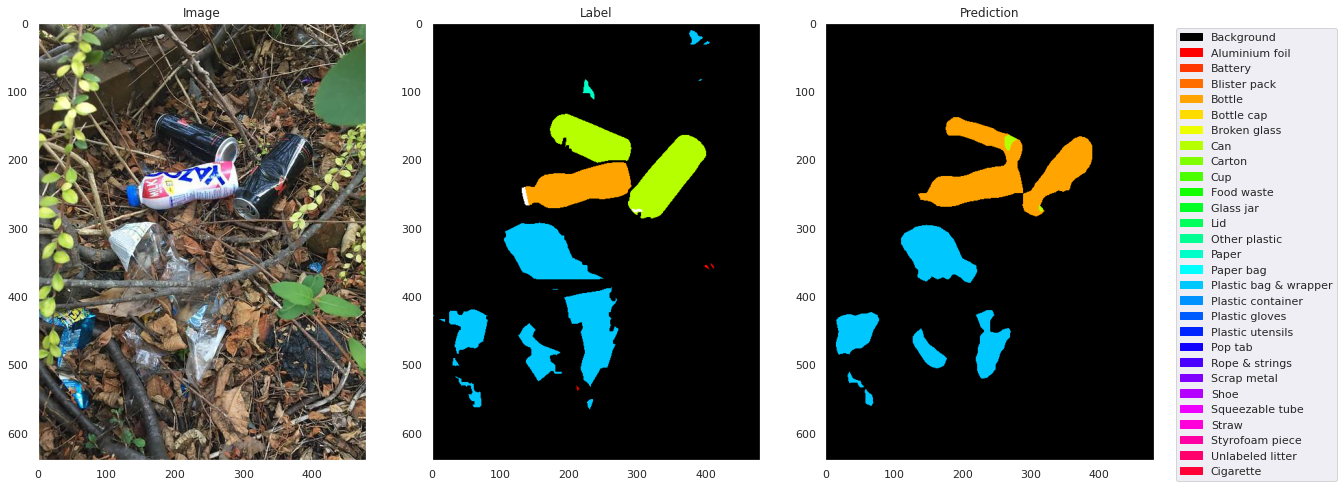

In [ ]:
dataset = get_taco_dataset(usePadding=False, randomCrop=False)
_, _, test_loader = get_dataloaders(dataset, batch_size=1)
model.eval()

image, mask = next(iter(test_loader))

if torch.cuda.is_available():
    input_batch = image.to('cuda')
    model.to('cuda')
else:
  input_batch = image

with torch.no_grad():
    output = model(input_batch)['out'][0]

output_predictions = output.argmax(0)
prediction = Image.fromarray(output_predictions.byte().cpu().numpy())

plot_image_mask_side_by_side(image, mask, prediction)